# Tutorial 4:  Using CNN for Image Classification

## Human Vision

In 1950, neurophysiology's David Hunter & Torsten Wiesel, at the John Hopkins School of Medicine, [theorized](https://www.cell.com/neuron/pdf/S0896-6273(00)80984-8.pdf) the existence of two types of cells in the human visual cortex that had something to do with the way we perceived patterns:

- __Simple Cells__ are cells that respond to edges of images of random orientation
- __Complex Cells__ can perform at the same level as the Simple Cells, but can do so anywhere in the image making this cell prone to Spatial Invariance

__Spatial Invariance__ is a property whereby the location of the “object of interest” does not affect the process our minds as well as machine leanring models as we’ll later in this tutorial.
__Complex cells__ are aided by simple cells via the summation of the output of several simple cells in different locations within the scope of ones vision. The concept of complex cells being comprised of the sum of simple cells renders these complex cells the __ability to detect features practically anywhere__ (i.e. spatially invariant) within the field of view.

This inspired the developement of [neocognitron](https://en.wikipedia.org/wiki/Neocognitron) which is one of the first multilayered artificial neural network. This led to later developement of Convolutional Neural Networks and SIFT (Scale Invariant Feature Transform).

## Computer Vision 

__Computer Vision (CV) is about extracting meaning out of an image/sequence of images (videos), making sense of a picture, and basically helping the computer see!__ Image Processing (ImgProc) should not be mixed with CV because ImgProc is mainly concerned with transforming images via many operations such as blurring, thresholding, and smoothing rather than extracting content or meaning from them. These operations are often used as part of CV algorithms.



## Convolutional Neural Networks (CNNs)

CNNs are an important tool for most machine learning practioners today. Following shows training a CNN model for Image classification task.

They are a subset of deep neural networks that exhibit the important trait of Spatial Invariance through kernel convolutions, which in our case is a simple dot product between two matrices, when it comes to Image Classification, and other applications (like Image Segmentation, Object Detection, Object Classification).

## Usefulness provided by CNNs

- __Parameter Sharing:__ Parameter sharing is an observation whereby we can use a single kernel/filter, with parameters consisting of its weights, to convolve over the same image multiple times effectively reducing the number of parameters you have to deal with per image, per kernel. In other words, __a filter used to convolve over a specific part of the image can also be useful in other parts of the image.__
- __Sparsity of Connections:__ Sparsity of connections is another observation whereby a single pixel in a feature map output, which is the product of convolving a kernel filter over a source image matrix, corresponds to a set of n x n pixels in the image, convolved with a filter, thus reducing number of connections images have with respect to the output (i.e. __1 Feature Map pixel ~ n x n set of image pixels convolved with the filter of size n__).

## Typical CNN Architecture

CNN image classifications takes an input image, process it and classify it under certain categories (Eg., Dog, Cat, Tiger, Lion). Computers sees an input image as array of pixels and it depends on the image resolution. Based on the image resolution, it will see h x w x d( h = Height, w = Width, d = Dimension ). Eg., An image of 6 x 6 x 3 array of matrix of RGB (3 refers to RGB values) and an image of 4 x 4 x 1 array of matrix of grayscale image.

Each input image will pass it through a series of convolution layers with filters (Kernals), Pooling, fully connected layers (FC) and apply Softmax function to classify an object with probabilistic values between 0 and 1. 

![CNN](data/images/17_cnn_architecture.png)

__The figure shows a complete flow of information in a CNN architecture to process an input image and classify based on values.__

## Feature Learning
 - __Convolution Operation:__
 
 Convolution is the first layer to extract features from an input image. Convolution preserves the relationship between pixels by learning image features using small squares of input data. Small squares are referred to as __filters__ or __kernels__.  It is a mathematical operation that takes two inputs such as image matrix and a filter or kernel. 
 
 <img src="https://www.freecodecamp.org/news/content/images/2019/07/convSobel.gif" />
  
 __commonly used filters:__
 
 <img src="./data/images/cnn_filters.png" />

__“convolving” allows the filter to extract what “it” thinks is an important feature, dictated by its weights__

__Multi-Channel Convolutions__: Above gifs show convolution operation on a single channel input matrix or image. When dealing with RGB images there are 3 channels (R, G, B). Therefore, a filter with 3 separate channels, one to capture details for each channel in the image is used. 

Once each channel in the filter has convolved over its appropriate channel in the image, an intermediate step is required whereby the results of the convolutions are simply added to get an overall result.

 <img src="./data/images/rgb_convolutions.gif" />


__Using Multiple filters for edge detection in RGB images__

 <img src="./data/images/multi_edge_filter.png" />


 - __Stride:__ 
 
 Stride is the number of pixels shifts over the input matrix. When stride is 1 then filter moves by 1 pixel. When stride is 2 the filter moves by 2 pixels and so on.
 
 - __Padding:__
 
 __The Border-Effect__ is a phenomenon whereby the n x n filter cannot capture the outer rows and columns of the image simply because a part of the filter would extend beyond the image where no pixels exist. This leads to information loss. It is solved by adding padding that introduces pixels of zero value all around the input image like shown below. This gives a resulting feature map that is equal to the image itself.  
 
 <img src="./utils/padding.gif" alt="Padding" title="Applying Padding Feature map = Input" />

 - __ReLU:__

 Rectified Linear Unit (ReLU) is one type of activation function defined as $ f(x) = max(0,x) $ that induces non-linearity to the inputs such that the output is not necessarily a linear combination of the inputs and weights. There are other activation functions like tanh, sigmoid, leakyReLU

 - __Max Pooling:__
 
 Pooling is a technique whereby we can down-sample feature maps, getting rid of any pixels that don’t necessarily represent the feature that we want to extract and still have the down-sampled map representative of the original map. It is also used to reduce the amount of parameters, and hence computations, needed throughout a CNN. Max Pooling returns the maximum value contained within the pool of values in the matrix superimposed on the image/feature.
 
 <img src="https://miro.medium.com/max/1204/0*uYmuSGuwM7N-88QT.gif" />

     
## Classification

 - __Fully Connected Layer__
 
 After extracting meaningful features using steps above the feature map is flatten into a 1-D vector which is assumed to be fully representative of the original input image. This vector is an input to a Fully Connected layer which is essentially learning non-linear combinations of these features.

 - __Softmax__
 
 The Softmax is a form of logistic regression that normalizes an input value into a vector of values that follows a probability distribution whose total sums up to 1.  
 
 $ \sigma(\vec{z})_{i} = e^{z_{i}} / \sum_{j=1} ^{K} e^{z_{j}} $
 



## Forward Pass and Backward Pass




![FWD_BACK PASS](https://drive.google.com/uc?id=1dgVg08M02gfIkPm0JKyhm4k4gYVLB_Me)

## Image classification

Using MNIST dataset.
MNIST (Modified National Institute of Standards and Technology) dataset is like the hello-world in computer vision. The dataset was
created way back in the late 90s. The official description states,

"The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting."

<img src="./data/images/mnist_samples.png" />


In [70]:
#Import Libraries


from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


In [71]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True

### load the data

In [72]:
# load the data
# MNIST can be directly used from pytorch's library interface (https://pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

### Building the Model 

Conv2d : torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

 - in_channels (int) – Number of channels in the input image
 - out_channels (int) – Number of channels produced by the convolution
 - kernel_size (int or tuple) – Size of the convolving kernel
 - stride (int or tuple, optional) – Stride of the convolution. (Default: 1)
 - padding (int or tuple, optional) – Zero-padding added to both sides of the input (Default: 0)
 - padding_mode (string, optional) – zeros
 
 Input : (N, $C_{in}$, $H_{in}$, $W_{in}$)
 
 Output : (N, $C_{out}$, $H_{out}$, $W_{out}$)

$ out(N_{i}, C_{out_{j}}) = bias(C_{out_{j}}) + \sum_{k=0} ^{C_{in} - 1} weight(C_{out_{j}}) * input(N_{i}, k) $

__Input/Output dimensions calculation for each Layer in CNN__

__conv1:__ Input image is $1x28x28$. Applying $5x5$ filter and $10$ feature maps, the $H$ and $W$ in the output of conv1 is calculated as, 

$ floor((28 + 2*0 - 1*(5-1) - 1)/2 + 1) $ , Refer [ $ H_{out}, W_{out} $formula](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).
The dividing by $2$ is due to the pooling kernel size of 2 in __forward()__. This gives Output dims = $10x12x12$

__conv2:__ Input feature map is $10x12x12$. Applying $5x5$ filter and $20$ feature maps, the $H$ and $W$ in the output of conv2 is calculated as, 

$ floor((12 + 2*0 - 1*(5-1) - 1)/2 + 1) $ , Refer [ $ H_{out}, W_{out} $formula](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).
The dividing by $2$ is due to the pooling kernel size of $2$ in __forward()__. This gives Output dims = $20x4x4$

__fc1:__ Input feature map is a 1-D vector of size $(,20*4*4)$ = $(,320)$ and Output dims is $(,50)$.

__fc2:__ Input feature map is of size $(,50)$ produced output vector of classes of dims $(,10)$


In [73]:
class Net(nn.Module):
    #This defines the structure of the NN.
    # Conv2d : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    # Dropout2d : https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html
    # Linear : https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # Input dims: (N, 1, 28, 28), Output dims: (N, 10, 12, 12)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # Input dims: (N, 10, 12, 12), Output dims: (N, 20, 4, 4)
        self.conv2_drop = nn.Dropout2d()  # Dropout Regularization
        self.fc1 = nn.Linear(320, 50) # Input dims: (N, 20 * 4 * 4), Output dims: (N, 50)
        self.fc2 = nn.Linear(50, 10) # Input dims: (N, 50), Output dims: (N, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) #default probability is p=0.5, and it is enabled only during training
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities. 
        return F.log_softmax(x, dim=1)

In [74]:

def train(epoch):
    tot_loss = 0
    model.train()
    print(len(train_loader))
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. 
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on parameter.
        optimizer.step()
        
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: NA'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
            

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False) #.data[0] # sum up batch loss
        #print(test_loss)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        #print(pred)
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


### Train

In [75]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    print(epoch)
    train(epoch)
    test()

1
60
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322318
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.301908
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.294072
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.272946
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.264783
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.255904


/home/smittal/anaconda3/envs/aiml_tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 2.2046, Accuracy: 4579/10000 (46%)

2
60
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.232731
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.208729
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.173880
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.133370
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.067923
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.001249

Test set: Average loss: 1.7481, Accuracy: 7482/10000 (75%)

3
60
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.924908
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.800300
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.685855
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.595824
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.413251
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.298075

Test set: Average loss: 0.8168, Accuracy: 8497/10000 (85%)

4
60
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.221900
Train Epoch: 4 [10000/60000 (17%)]	Loss: 1.142941
Train Epoch: 4 [20000/60000 (33%)]	Loss: 1.054515
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.965103
Train Epoch: 4 [4

## Eval

/home/smittal/anaconda3/envs/aiml_tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


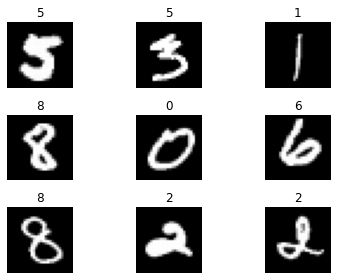


Test set: Average loss: 0.2427, Accuracy: 9303/10000 (93%)



In [76]:
import matplotlib.pyplot as plt 
# Plots are plotted inside the notebooks, 'inline'
%matplotlib inline 
import numpy as np

model.eval()
test_loss = 0
correct = 0
pred = None
dataset = None
for data, target in test_loader:
    dataset = data
    if args['cuda']:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    
    test_loss += F.nll_loss(output, target, size_average=False) #.data[0] # sum up batch loss
    
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    
    correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

figure = plt.figure() #figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows +1): #range(4):
    figure.add_subplot(rows, cols, i)
    plt.imshow(dataset[i-1].numpy().reshape((28,28)).squeeze(), cmap='gray')
    label = np.asarray(pred[i-1].data[0].cpu())
    plt.title(label)
    plt.axis("off")
figure.tight_layout()
plt.show()

test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
